## Device configuration

In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  
print(device)

mps


## Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(1, 32, kernel_size=(3,3))
        self.l2 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.l3 = nn.Linear(1600, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.l1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.l2(x)), (2,2))
        return self.l3(F.dropout(x.flatten(1), 0.5, self.training))

## Get the MNIST dataset

In [3]:
from tinygrad.nn.datasets import mnist

X_train, Y_train, X_test, Y_test = mnist()

# Convert tinygrad Tensors to PyTorch tensors 
X_train = torch.from_numpy(X_train.numpy()).float().reshape(-1, 1, 28, 28) 
Y_train = torch.from_numpy(Y_train.numpy()).long()
X_test = torch.from_numpy(X_test.numpy()).float().reshape(-1, 1, 28, 28) 
Y_test = torch.from_numpy(Y_test.numpy()).long()

print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)

torch.Size([60000, 1, 28, 28]) torch.float32 torch.Size([60000]) torch.int64


## Use the model

In [4]:
model = Model()
acc = (model(X_test).argmax(axis=1) == Y_test).float().mean()
print(acc.item())  

0.10000000149011612


In [5]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
| l1.weight |    288     |
|  l1.bias  |     32     |
| l2.weight |   18432    |
|  l2.bias  |     64     |
| l3.weight |   16000    |
|  l3.bias  |     10     |
+-----------+------------+
Total Trainable Params: 34826



34826

### Train the model

In [6]:
optim = torch.optim.Adam(model.parameters())
batch_size = 128
def training_step():
    model.train()  # enables dropout
    samples = torch.randint(high=X_train.shape[0], size=(batch_size,))
    X, Y = X_train[samples], Y_train[samples]
    optim.zero_grad()
    loss = F.nll_loss(F.log_softmax(model(X), dim=1), Y)
    loss.backward()
    optim.step()
    return loss

In [7]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

for step in range(7000):
    # Calculate train loss
    loss = training_step()  
    train_losses.append(loss.item())
    
    if step % 100 == 0:
        model.eval()  # Disables dropout for evaluation
        
        with torch.no_grad():
            # Calculate train accuracy
            train_outputs = model(X_train)
            train_acc = (train_outputs.argmax(dim=1) == Y_train).float().mean().item()
            train_accuracies.append(train_acc)

            # Calculate test accuracy
            test_outputs = model(X_test)
            test_acc = (test_outputs.argmax(dim=1) == Y_test).float().mean().item()
            test_accuracies.append(test_acc)

            # Calculate test loss
            test_loss = F.nll_loss(F.log_softmax(model(X_test), dim=1), Y_test).item()
            test_losses.append(test_loss)

        print(f"step {step:4d}, loss {loss.item():.2f}, train acc {train_acc*100.:.2f}%, test acc {test_acc*100.:.2f}%")
        model.train()  # Re-enables dropout for training

step    0, loss 52.37, train acc 8.21%, test acc 7.62%


### Plot the loss

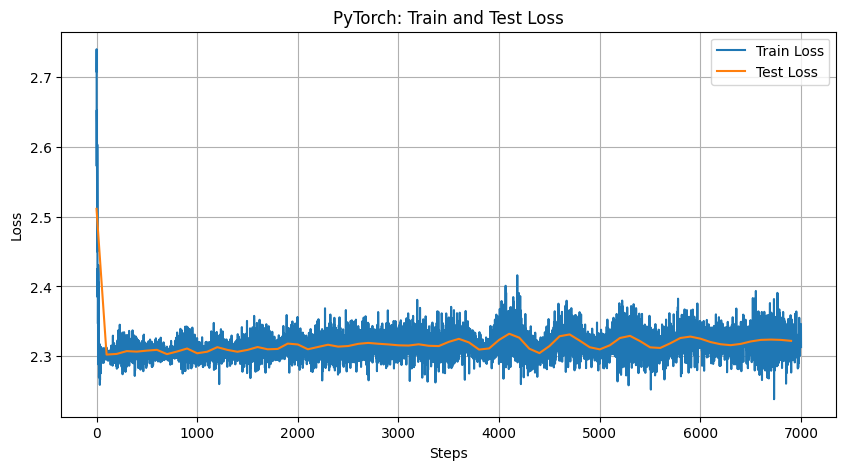

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(0, len(test_losses) * 100, 100), test_losses, label='Test Loss') # every 100 steps
plt.title('PyTorch: Train and Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plot the accuracy 

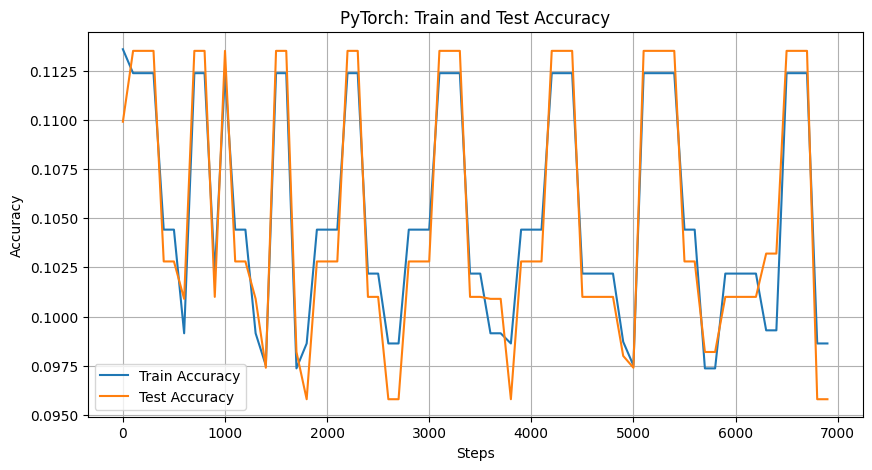

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, len(train_accuracies) * 100, 100), train_accuracies, label='Train Accuracy')
plt.plot(range(0, len(test_accuracies) * 100, 100), test_accuracies, label='Test Accuracy')
plt.title('PyTorch: Train and Test Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Save the weights

In [22]:
import numpy as np

# Save PyTorch model weights in .npy format
pytorch_weights = {
    'l1.weight': model.l1.weight.detach().numpy(),
    'l1.bias': model.l1.bias.detach().numpy(),
    'l2.weight': model.l2.weight.detach().numpy(),
    'l2.bias': model.l2.bias.detach().numpy(),
    'l3.weight': model.l3.weight.detach().numpy(),
    'l3.bias': model.l3.bias.detach().numpy()
}
np.save('pytorch_weights.npy', pytorch_weights)

## Final probabilities

In [23]:
test_image = X_test[0:1]
model.eval()
with torch.no_grad():
    pytorch_probs = F.softmax(model(test_image), dim=1).numpy()
print("PyTorch probabilities:", pytorch_probs)

PyTorch probabilities: [[0.08632541 0.09982429 0.06834638 0.08663069 0.13217027 0.07748631
  0.11366978 0.10336349 0.12171686 0.11046653]]


## Export to ONNX format

In [24]:
import torch.onnx

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, 
                  dummy_input, 
                  "mnist_model.onnx")